In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import time
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 16

# Load the dataset
dataset = datasets.ImageFolder(root='./cnn_dataset/', transform=transform)

# Dataset split into training, validation and testing set
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in trainloader:
    print(image.shape[1])
    break

3


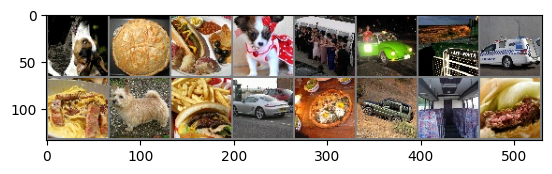

dogs  food  food  dogs  vehicles vehicles vehicles vehicles food  dogs  food  vehicles food  vehicles vehicles food 


In [6]:
classes = dataset.classes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
modelCNN = CNN()
print(modelCNN)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=36, bias=True)
)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001)

In [14]:
# Start time
startTime = time.time()

training_loss_plt_arr = []
validation_loss_plt_arr = []
testing_loss_plt_arr = []

epochs = 2
# Epoch Iteration
for epoch in range(epochs):
    training_loss = 0.0
    
    #Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = modelCNN(inputs)
        loss_training = criterion(outputs, labels)
        loss_training.backward()
        optimizer.step()

        training_loss += loss_training.item()
        if i % 500 == 499:
            
            # Validation loop
            validation_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    loss_validation = criterion(outputs, labels)
                    validation_loss += loss_validation.item()
            
            # Testing loop
            testing_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    loss_testing = criterion(outputs, labels)
                    testing_loss += loss_testing.item()

            print(f"[{epoch + 1}, {i + 1}], Training loss: {training_loss / 500:.3f}, Validation loss: {validation_loss / len(valloader):.3f}, Testing loss: {testing_loss / len(testloader):.3f}")
            training_loss_plt_arr.append(round((training_loss / 500),3))
            validation_loss_plt_arr.append(round((validation_loss / len(valloader)),3))
            testing_loss_plt_arr.append(round((testing_loss / len(testloader)),3))
            training_loss = 0.0

print("Finished Training")
    
# End time
endTime = time.time()
time_to_train = (endTime - startTime)
print(f"\nTime to train = {time_to_train:.2f}\n")

[1, 500], Training loss: 0.711, Validation loss: 0.449, Testing loss: 0.456
[1, 1000], Training loss: 0.472, Validation loss: 0.465, Testing loss: 0.443
[1, 1500], Training loss: 0.435, Validation loss: 0.395, Testing loss: 0.388
[2, 500], Training loss: 0.388, Validation loss: 0.396, Testing loss: 0.374
[2, 1000], Training loss: 0.363, Validation loss: 0.360, Testing loss: 0.354
[2, 1500], Training loss: 0.361, Validation loss: 0.369, Testing loss: 0.341
Finished Training

Time to train = 252.22



In [18]:
# Normalize Losses for better visualisation
def normalizedLossesPlot():
    training_loss_plt_arr_max = max(training_loss_plt_arr)
    training_loss_plt_arr_min = min(training_loss_plt_arr)
    validation_loss_plt_arr_max = max(validation_loss_plt_arr)
    validation_loss_plt_arr_min = min(validation_loss_plt_arr)
    testing_loss_plt_arr_max = max(testing_loss_plt_arr)
    testing_loss_plt_arr_min = min(testing_loss_plt_arr)

    training_loss_minmax_deno = training_loss_plt_arr_max - training_loss_plt_arr_min
    validation_loss_minmax_deno = validation_loss_plt_arr_max - validation_loss_plt_arr_min
    testing_loss_minmax_deno = testing_loss_plt_arr_max - testing_loss_plt_arr_min

    training_loss_plt_arr_norm = [(i - training_loss_plt_arr_min)/training_loss_minmax_deno for i in training_loss_plt_arr]
    validation_loss_plt_arr_norm = [(i - validation_loss_plt_arr_min)/validation_loss_minmax_deno for i in validation_loss_plt_arr]
    testing_loss_plt_arr_norm = [(i - testing_loss_plt_arr_min)/testing_loss_minmax_deno for i in testing_loss_plt_arr]

    # Plot the loss graph
    plt.plot(range(1, 7), training_loss_plt_arr_norm, label='Training Loss', color='red')
    plt.plot(range(1, 7), validation_loss_plt_arr_norm, label='Validation Loss', color='green')
    plt.plot(range(1, 7), testing_loss_plt_arr_norm, label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [20]:
# Performance Evaluation
import seaborn as sns
def loadersAccuracy(loader):
    modelCNN.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = modelCNN(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            #ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())
    
    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC

def perfEvaluation():
    modelCNN.eval()
        
    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC= loadersAccuracy(testloader)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

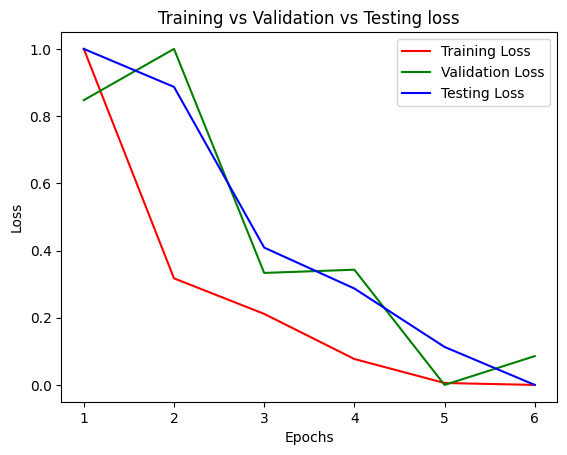

Accuracy on the testing dataset = 86.97


In [21]:
normalizedLossesPlot()
perfEvaluation()